In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import scanpy as sc
import sklearn
from scipy.sparse import csr_matrix
from sklearn.metrics.cluster import adjusted_rand_score
import copy

# os.chdir('/Users/evanli/Documents/Research_datasets/PBMC_Hao')
adata_raw = sc.read('Hao_PBMC.h5ad')
print(adata_raw.shape)  # row is cells, column is gene
# (161764, 20568)

NameError: name 'adata' is not defined

In [3]:
adata_raw

AnnData object with n_obs × n_vars = 161764 × 20568
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor_id', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'cell_type_ontology_term_id', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'assay_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: 'celltype.l3_colors', 'default_embedding', 'neighbors', 'schema_version', 'title'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap'
    varm: 'PCs', 'SPCA'
    layers: 'corrected_counts'
    obsp: 'distances'

In [4]:
# In[] Metadata
types_l1 = adata_raw.obs['celltype.l1'].unique()  # 8
types_l2 = adata_raw.obs['celltype.l2'].unique()  # 31
types_l3 = adata_raw.obs['celltype.l3'].unique()  # 58

celltype_df = adata_raw.obs[['celltype.l1', 'celltype.l2', 'cell_type']]
# levels = celltype_df.groupby(['celltype.l1', 'celltype.l2', 'celltype.l3']).count()
celltype_df = celltype_df.sort_values(['celltype.l1', 'celltype.l2'])

celltype_dict = {k:[] for k in sorted(types_l1)}
for i in range(len(celltype_df)):
    level_1 = celltype_df.iloc[i, 0]
    level_2 = celltype_df.iloc[i, 1]
    if level_2 not in celltype_dict[level_1]:
        celltype_dict[level_1].append(level_2)

# import json
# celltype_json = json.dumps(celltype_dict,indent=4)
# with open('Celltype_hierarchy.json', 'w') as file:
#     file.write(celltype_json)


In [5]:
types_l1

['Mono', 'CD4 T', 'CD8 T', 'NK', 'B', 'other T', 'other', 'DC']
Categories (8, object): ['B', 'CD4 T', 'CD8 T', 'DC', 'Mono', 'NK', 'other', 'other T']

In [6]:
list(types_l2)

['CD14 Mono',
 'CD4 TCM',
 'CD8 Naive',
 'NK',
 'CD8 TEM',
 'CD16 Mono',
 'B intermediate',
 'CD4 Naive',
 'CD4 CTL',
 'B naive',
 'MAIT',
 'gdT',
 'CD8 TCM',
 'dnT',
 'B memory',
 'Doublet',
 'pDC',
 'CD8 Proliferating',
 'Treg',
 'Plasmablast',
 'CD4 TEM',
 'cDC2',
 'NK Proliferating',
 'ASDC',
 'HSPC',
 'Platelet',
 'NK_CD56bright',
 'CD4 Proliferating',
 'Eryth',
 'cDC1',
 'ILC']

## Filtering

In [7]:
adata = copy.deepcopy(adata_raw)

In [8]:
# Basic filtering: (161764, 20568) to (161748, 20556)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [9]:
adata.shape

(161748, 20556)

In [11]:
# Mitochondrial percentage
adata.var['MT'] = adata.var['feature_name'].str.startswith('MT-')

# calculate metrics and store in adata.var
sc.pp.calculate_qc_metrics(adata, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)
adata.obs['log10_n_genes_by_counts'] = np.log10(adata.obs.n_genes_by_counts + 1)

# sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_MT', 'log10_n_genes_by_counts'],
#              jitter=False, multi_panel=True)


In [12]:
# Total-count normalize the data matrix X to 10,000 reads per cell
sc.pp.normalize_total(adata, target_sum=1e4)
# Log
sc.pp.log1p(adata)


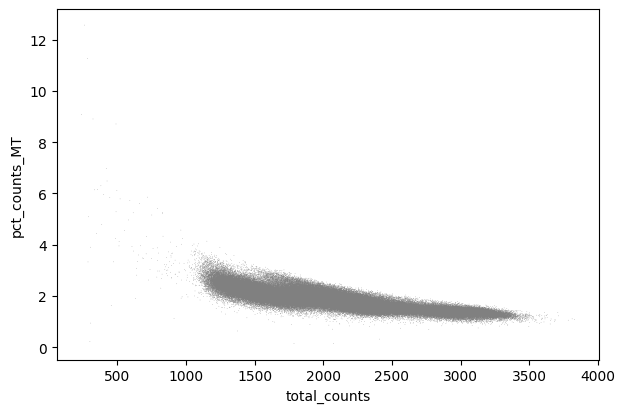

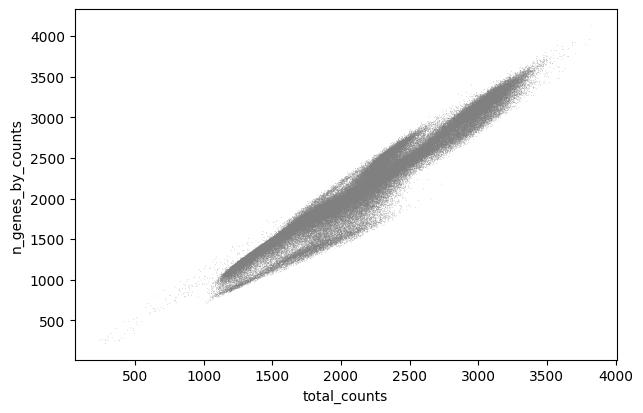

In [13]:
# Scatter plot
sc.pl.scatter(adata, x='total_counts', y='pct_counts_MT')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')


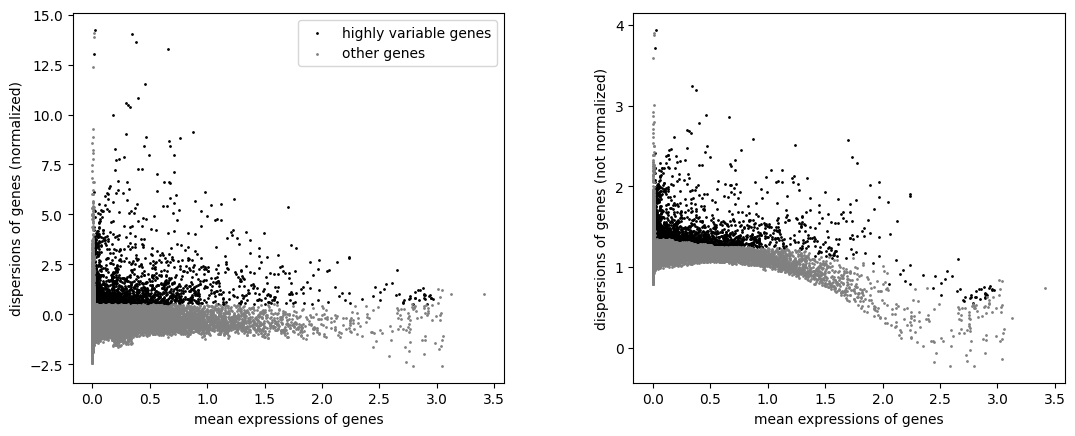

2586

In [14]:
# Highly variable gene selection 
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

# How many HVGs
sum(adata.var['highly_variable'])  # 2586


In [15]:
# filtering the non-Highly variable genes in data
adata = adata[:, adata.var.highly_variable]  # choose columns, Genes
adata.shape  # (161748, 2586)


(161748, 2586)

In [16]:
adata.obs.columns

Index(['nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA',
       'orig.ident', 'lane', 'donor_id', 'time', 'celltype.l1', 'celltype.l2',
       'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT',
       'cell_type_ontology_term_id', 'sex_ontology_term_id',
       'self_reported_ethnicity_ontology_term_id',
       'development_stage_ontology_term_id', 'disease_ontology_term_id',
       'assay_ontology_term_id', 'is_primary_data',
       'organism_ontology_term_id', 'tissue_ontology_term_id',
       'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex',
       'tissue', 'self_reported_ethnicity', 'development_stage', 'n_genes',
       'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT',
       'log10_n_genes_by_counts'],
      dtype='object')

### Cell filtering

In [20]:
print(adata.obs['pct_counts_MT'].quantile([0.25, 0.5, 0.75]))

0.25    1.514159
0.50    1.786165
0.75    2.091000
Name: pct_counts_MT, dtype: float64


In [21]:
print(adata.obs['n_genes_by_counts'].quantile([0.25, 0.5, 0.75]))

0.25    1580.0
0.50    2023.0
0.75    2504.0
Name: n_genes_by_counts, dtype: float64


In [22]:
print(adata.obs['total_counts'].quantile([0.25, 0.5, 0.75]))

0.25    1668.089020
0.50    2105.174438
0.75    2431.684082
Name: total_counts, dtype: float64


In [23]:
print(adata.obs['n_genes'].quantile([0.25, 0.5, 0.75]))

0.25    1580.0
0.50    2023.0
0.75    2504.0
Name: n_genes, dtype: float64


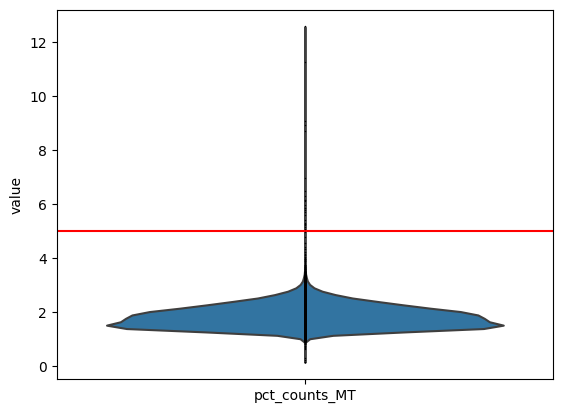

In [57]:
# del ax
import matplotlib.pyplot as plt

# sc.pl.violin(adata, ['pct_counts_MT', 'total_counts', 'n_genes'],
#              jitter=False, multi_panel=True)

fig, ax = plt.subplots()
ax.axhline(y=5, color='red')

# Plot violin plot
sc.pl.violin(adata, 'pct_counts_MT', jitter=False, ax=ax)

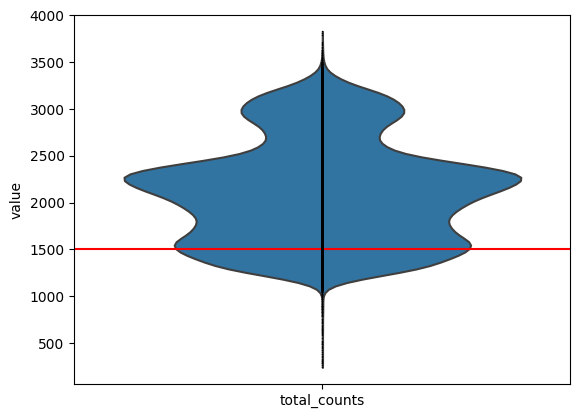

In [58]:
fig, ax = plt.subplots()
ax.axhline(y=1500, color='red')

sc.pl.violin(adata, 'total_counts', jitter=False, ax=ax)

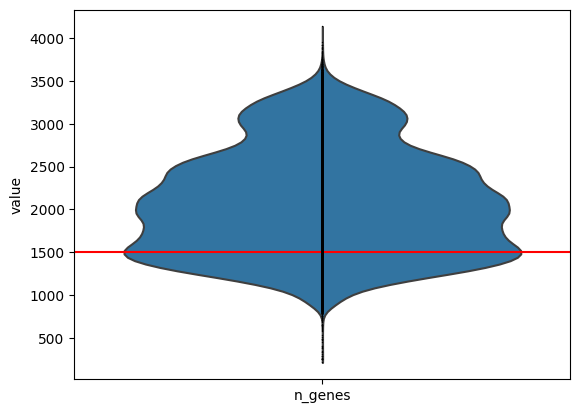

In [59]:
fig, ax = plt.subplots()
ax.axhline(y=1500, color='red')

sc.pl.violin(adata, 'n_genes', jitter=False, ax=ax)

In [62]:
# Cell filtering
# mitochondrial < 10%
adata = adata[adata.obs.pct_counts_MT < 5, :]
# log10GenesPerUMI > 0.8
# adata = adata[adata.obs.log10_n_genes_by_counts > 0.8, :]
# UMI count > 1500
adata = adata[adata.obs.total_counts > 1500, :]
# gene number > 1500
adata = adata[adata.obs.n_genes > 1500, :]
print(adata.shape)

(129153, 2586)


In [63]:
# adata.write('Hao_PBMC_filtered.h5ad')

## Visualization

In [34]:
# adata = sc.read('Hao_PBMC_filtered.h5ad')

# Delete the 'neighbors' key from adata.uns
# if 'neighbors' already exists in adata.uns, error would occurs at sc.pp.neighbors
if 'neighbors' in adata.uns:
    del adata.uns['neighbors']

In [45]:
# del adata.uns['neighbors']
del adata.uns['neighbors']['params']

In [46]:
adata.uns

{'celltype.l3_colors': array(['#FFFF00', '#1CE6FF', '#FF34FF', '#FF4A46', '#008941', '#006FA6',
        '#A30059', '#FFDBE5', '#7A4900', '#0000A6', '#63FFAC', '#B79762',
        '#004D43', '#8FB0FF', '#997D87', '#5A0007', '#809693', '#6A3A4C',
        '#1B4400', '#4FC601', '#3B5DFF', '#4A3B53', '#FF2F80', '#61615A',
        '#BA0900', '#6B7900', '#00C2A0', '#FFAA92', '#FF90C9', '#B903AA',
        '#D16100', '#DDEFFF', '#000035', '#7B4F4B', '#A1C299', '#300018',
        '#0AA6D8', '#013349', '#00846F', '#372101', '#FFB500', '#C2FFED',
        '#A079BF', '#CC0744', '#C0B9B2', '#C2FF99', '#001E09', '#00489C',
        '#6F0062', '#0CBD66', '#EEC3FF', '#456D75', '#B77B68', '#7A87A1',
        '#788D66', '#885578', '#FAD09F', '#FF8A9A'], dtype=object),
 'default_embedding': 'X_wnn.umap',
 'neighbors': {},
 'schema_version': '3.0.0',
 'title': 'nygc multimodal pbmc',
 'log1p': {'base': None},
 'hvg': {'flavor': 'seurat'},
 'pca': {'params': {'zero_center': True, 'use_highly_variable': True},
 

/home/evanlee/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/evanlee/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


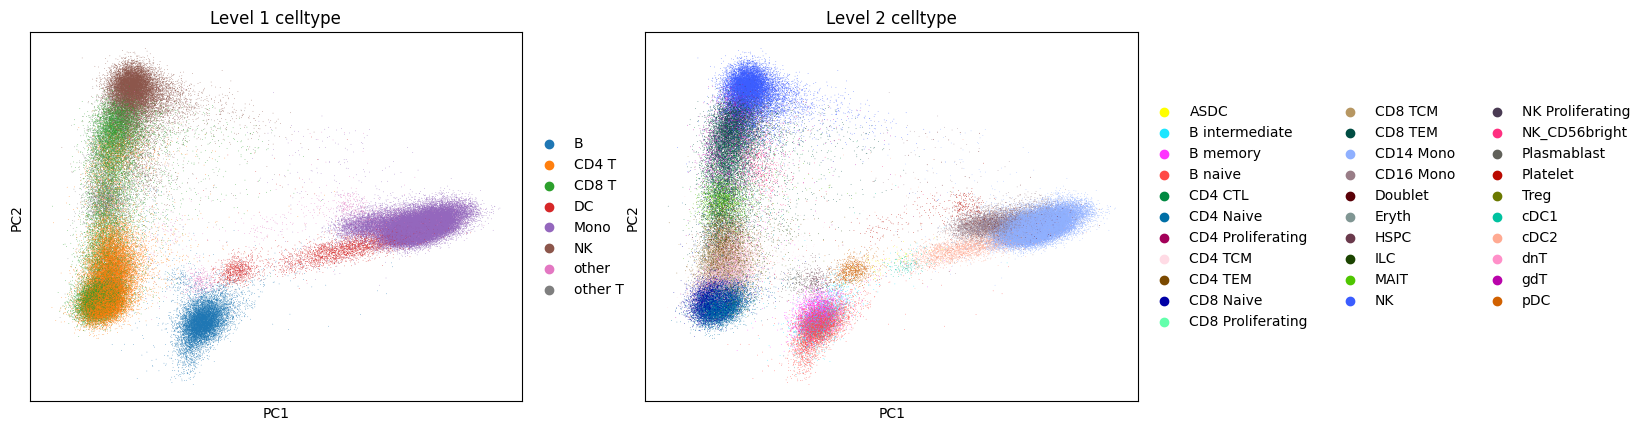

In [40]:
# In[] PCA

sc.tl.pca(adata, svd_solver='arpack')
# sc.pl.pca(adata)
sc.pl.pca(adata, color=['celltype.l1', 'celltype.l2'], title=['Level 1 celltype', 'Level 2 celltype'])

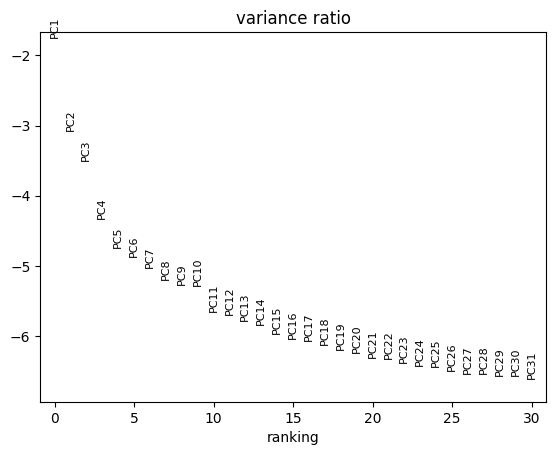

In [41]:
# Plot PCA variance ratio
sc.pl.pca_variance_ratio(adata, log=True)

In [47]:
# neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

/home/evanlee/.local/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/evanlee/.local/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/evanlee/.local/lib/python3.8/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: Th

/home/evanlee/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/evanlee/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


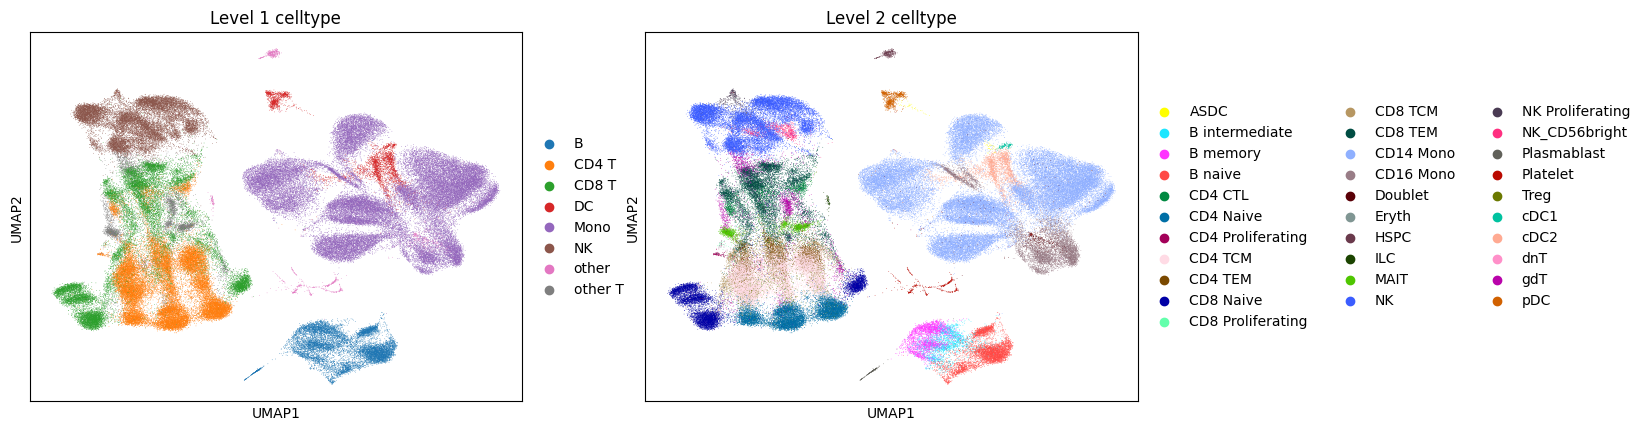

In [48]:
# UMAP

sc.tl.umap(adata)
# sc.pl.umap(adata)
sc.pl.umap(adata, color=['celltype.l1', 'celltype.l2'], title=['Level 1 celltype', 'Level 2 celltype'])

In [ ]:
# In[] t-SNE

sc.tl.tsne(adata)
# sc.pl.tsne(adata)
sc.pl.tsne(adata, color=['celltype.l1', 'celltype.l2'], title=['Level 1 celltype', 'Level 2 celltype'])


In [52]:
# Leiden clustering
sc.tl.leiden(adata)
# 33 leiden clusters

/home/evanlee/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/evanlee/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


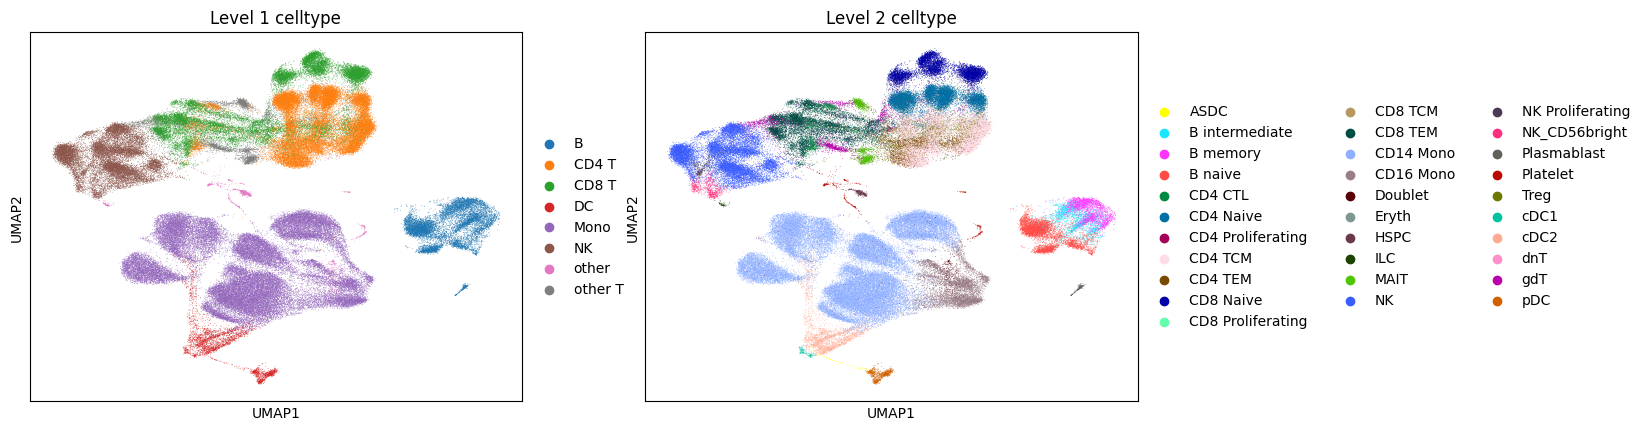

In [58]:
# UMAP with PAGA position
sc.tl.paga(adata, groups='celltype.l1')
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')
sc.pl.umap(adata, color=['celltype.l1', 'celltype.l2'], title=['Level 1 celltype', 'Level 2 celltype'])

## Leiden

/home/evanlee/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/evanlee/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


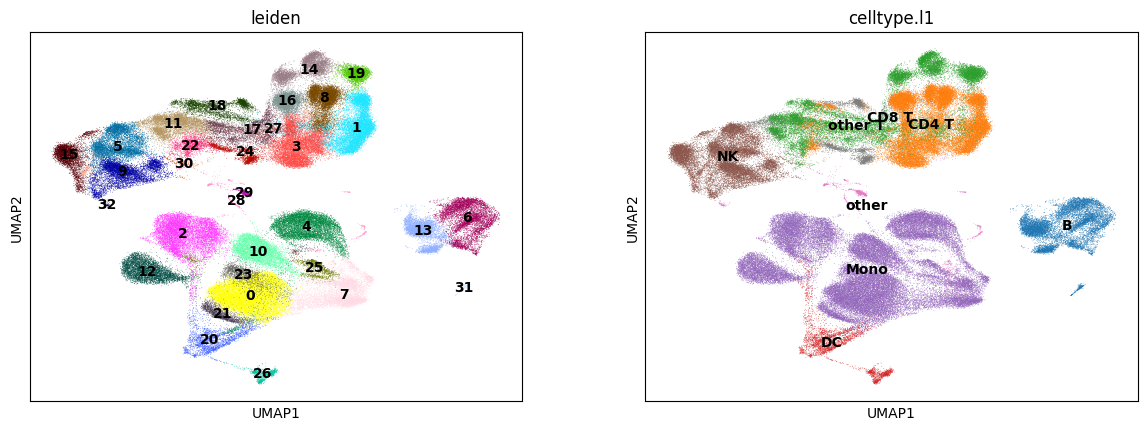

In [59]:
# Plot Leiden
sc.tl.paga(adata, groups='celltype.l1')
sc.pl.paga(adata, plot=False)
sc.tl.umap(adata, init_pos='paga')
sc.pl.umap(adata, color=['leiden', 'celltype.l1'], legend_loc="on data")

## Finding marker genes (rank genes groups)

/home/evanlee/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


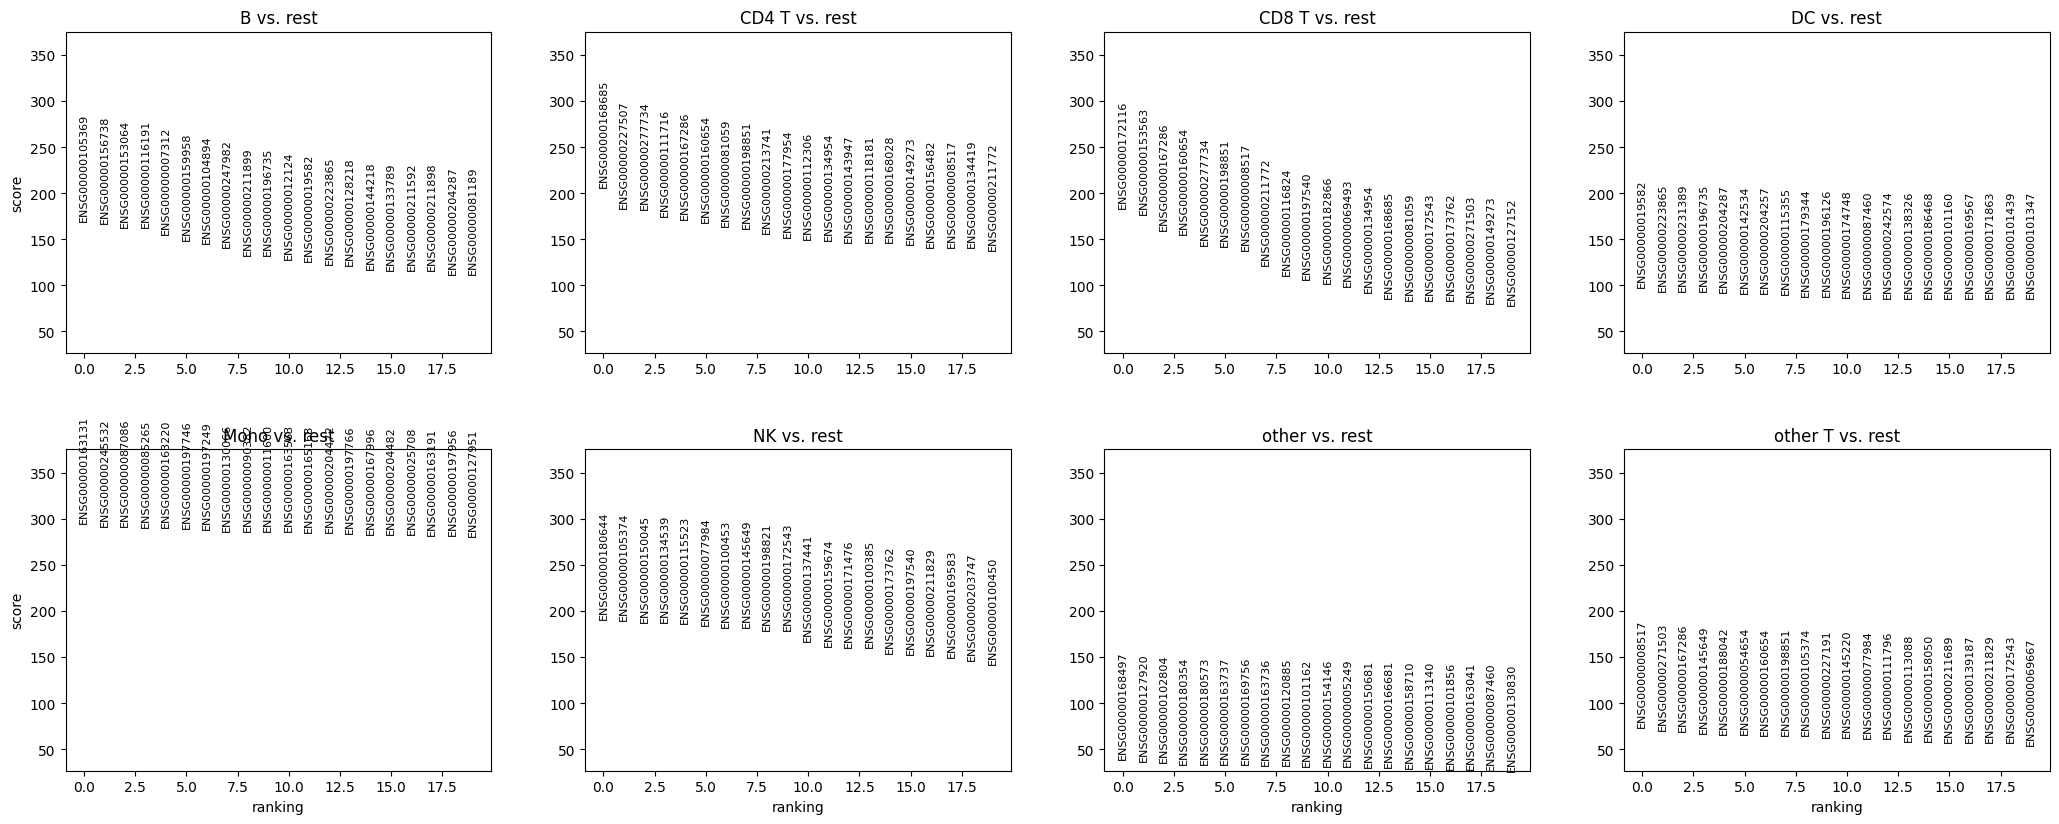

In [64]:
sc.tl.rank_genes_groups(adata, groupby='celltype.l1', method='wilcoxon')
sc.pl.rank_genes_groups(adata)
# saved to adata.uns

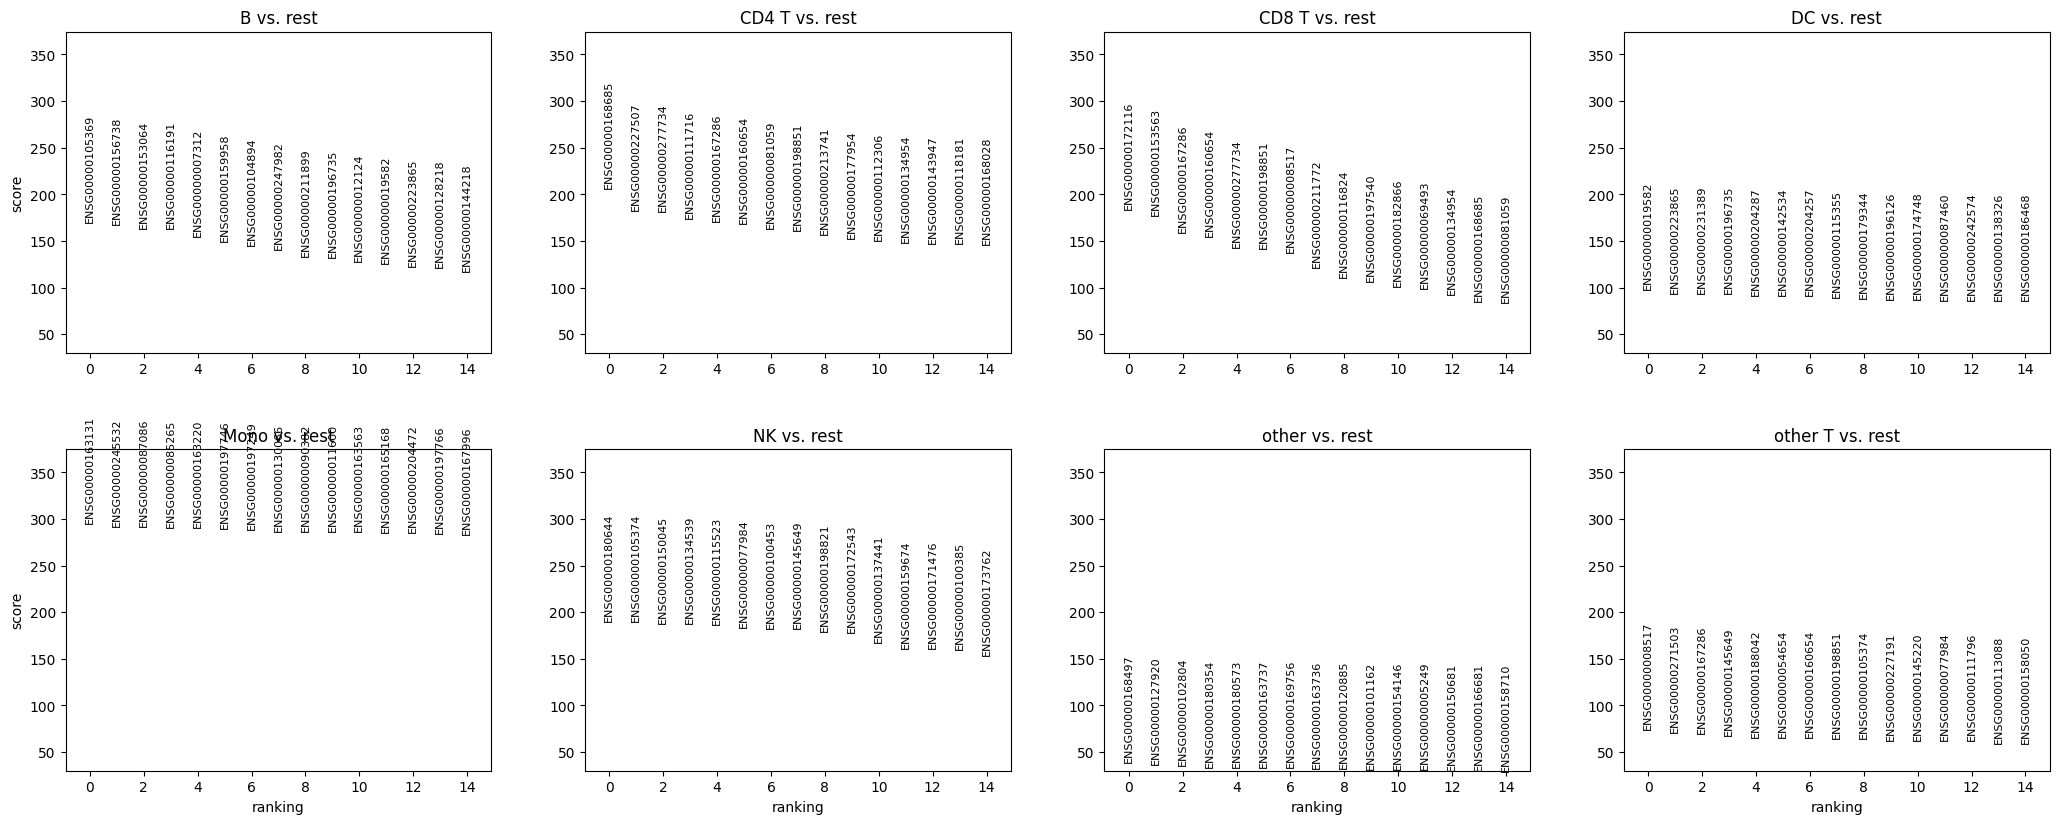

In [66]:
sc.pl.rank_genes_groups(adata, n_genes=15)

In [ ]:
sc.pl.rank_genes_groups(adata)

In [61]:
adata.uns['rank_genes_groups']

{'params': {'groupby': 'celltype.l1',
  'reference': 'rest',
  'method': 'wilcoxon',
  'use_raw': True,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('ENSG00000105369', 'ENSG00000168685', 'ENSG00000172116', 'ENSG00000019582', 'ENSG00000163131', 'ENSG00000180644', 'ENSG00000168497', 'ENSG00000008517'),
            ('ENSG00000156738', 'ENSG00000227507', 'ENSG00000153563', 'ENSG00000223865', 'ENSG00000245532', 'ENSG00000105374', 'ENSG00000127920', 'ENSG00000271503'),
            ('ENSG00000153064', 'ENSG00000277734', 'ENSG00000167286', 'ENSG00000231389', 'ENSG00000087086', 'ENSG00000150045', 'ENSG00000102804', 'ENSG00000167286'),
            ...,
            ('ENSG00000135046', 'ENSG00000011600', 'ENSG00000011600', 'ENSG00000008517', 'ENSG00000008517', 'ENSG00000125691', 'ENSG00000198851', 'ENSG00000158869'),
            ('ENSG00000126264', 'ENSG00000169554', 'ENSG00000167996', 'ENSG00000211772', 'ENSG00000211772', 'ENSG00000110700', 'ENSG00000188042', 'EN

In [62]:
adata.uns['rank_genes_groups']['names']

rec.array([('ENSG00000105369', 'ENSG00000168685', 'ENSG00000172116', 'ENSG00000019582', 'ENSG00000163131', 'ENSG00000180644', 'ENSG00000168497', 'ENSG00000008517'),
           ('ENSG00000156738', 'ENSG00000227507', 'ENSG00000153563', 'ENSG00000223865', 'ENSG00000245532', 'ENSG00000105374', 'ENSG00000127920', 'ENSG00000271503'),
           ('ENSG00000153064', 'ENSG00000277734', 'ENSG00000167286', 'ENSG00000231389', 'ENSG00000087086', 'ENSG00000150045', 'ENSG00000102804', 'ENSG00000167286'),
           ...,
           ('ENSG00000135046', 'ENSG00000011600', 'ENSG00000011600', 'ENSG00000008517', 'ENSG00000008517', 'ENSG00000125691', 'ENSG00000198851', 'ENSG00000158869'),
           ('ENSG00000126264', 'ENSG00000169554', 'ENSG00000167996', 'ENSG00000211772', 'ENSG00000211772', 'ENSG00000110700', 'ENSG00000188042', 'ENSG00000103187'),
           ('ENSG00000082074', 'ENSG00000051523', 'ENSG00000158869', 'ENSG00000127528', 'ENSG00000134954', 'ENSG00000198918', 'ENSG00000133639', 'ENSG000000345